# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# 1. Setup

### 1a. Load BioImage Models

- https://doi.org/10.5281/zenodo.6200999
- https://doi.org/10.5281/zenodo.6200635

In [1]:
import bioimageio.core

bioimageio.core.export_resource_package("10.5281/zenodo.6200999", output_path="model-nuc.zip")
nuc_model = bioimageio.core.load_resource_description("model-nuc.zip")

bioimageio.core.export_resource_package("10.5281/zenodo.6200635", output_path="model-cell.zip")
cell_model = bioimageio.core.load_resource_description("model-cell.zip")

site.config.json: 6.57kiB [00:00, 1.52MiB/s]                                                      
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (6568) does not have expected size (2289).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
collection.json: 235kiB [00:00, 29.5MiB/s]                                                        
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (234788) does not have expected size (28539).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
rdf.yaml: 3.05kiB [00:00, 843kiB/s]                                                               
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (3053) does not have expected size (1218).
  warnings.warn(f"Download ({t.

### 1b. Create Prediction Pipelines

In [3]:
from bioimageio.core.prediction import predict_with_padding

from xarray import DataArray
from skimage.measure import label
from skimage.segmentation import watershed

pp_nucleus = bioimageio.core.create_prediction_pipeline(bioimageio_model=nuc_model)
pp_cell = bioimageio.core.create_prediction_pipeline(bioimageio_model=cell_model)

### 1c. Prepare Image Dataset

In [4]:
# red microtubule, blue nuclei, green protein, yellow endoplasmic reticulum
channels = ["red", "blue", "green"]
scale_factor = 0.25

In [5]:
hpa_cyto = "921_B9_1_"
hpa_endo = "1876_A7_32_"
hpa_mito = "946_E10_1_"
hpa_nucl = "962_F1_1_"

In [6]:
image_paths = dict()
for hpa in [hpa_cyto, hpa_endo, hpa_mito, hpa_nucl]:
    filepaths = []
    for channel in channels:
        filepaths.append("images/" + hpa + channel + ".png")
    image_paths[hpa] = filepaths

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from skimage.transform import rescale

In [8]:
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp]
        path = path[0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

# 2. Analysis

### 2a. Select Dataset

In [29]:
hpa = hpa_endo

### 2b. Load Images

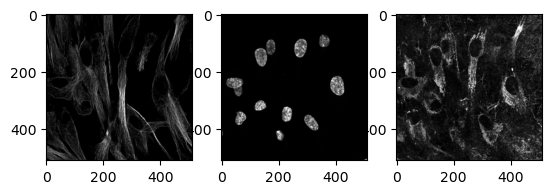

In [30]:
image = load_image(image_paths[hpa], channels, scale_factor)

fig, axes = plt.subplots(1,len(channels))
for i in range(len(channels)):
    axes[i].imshow(image[i,:,:], cmap='gray')

### 2c.Identify Nuclei

In [31]:
axes = cell_model.inputs[0].axes
input_nucleus = DataArray(
    np.concatenate([image[1:2], image[1:2], image[1:2]], axis=0)[None],
    dims=axes
)
padding = {"x": 32, "y": 32}
nuclei_pred = predict_with_padding(pp_nucleus, input_nucleus, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


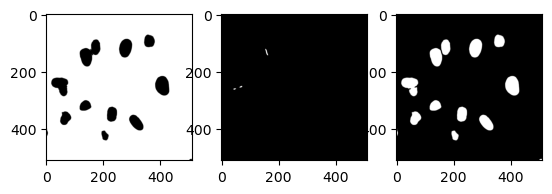

In [32]:
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(nuclei_pred[i,:,:], cmap='gray')

In [33]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [34]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

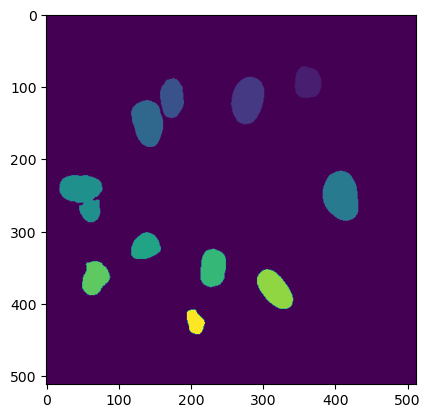

In [35]:
plt.subplots()
plt.imshow(nuclei)

### 2d. Identify Cells

In [36]:
axes = cell_model.inputs[0].axes
input_cells = DataArray(image[None], dims=axes)
cell_pred = predict_with_padding(pp_cell, input_cells, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


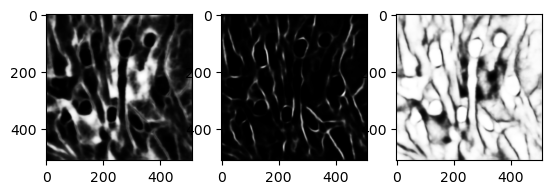

In [37]:
fix, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(cell_pred[i], cmap='gray')

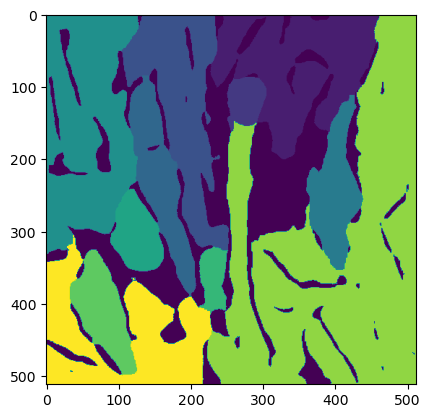

In [38]:
fg, bd = cell_pred[2], cell_pred[1]
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [39]:
ids, sizes = np.unique(cell_seg, return_counts=True)

In [40]:
sizes

array([46282, 25559,  3040, 21321, 11155,  9757, 31443,  5628,  2740,
        8064, 75981, 21174])

# 3. Exercises

- Explain the parameters provided to watershed().  What happens when you remove mask?  What happens when you remove markers?
- Compare how well segmentation works for cyto, endo, mito, and nucl.  What types of samples work well?  Not as well?

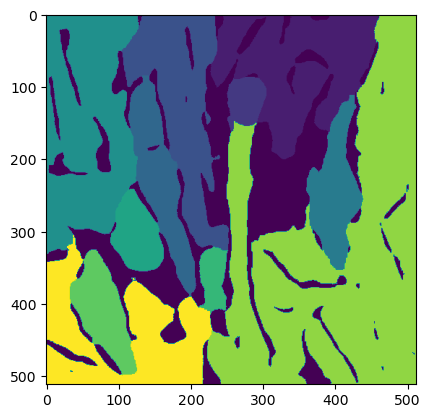

In [41]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [22]:
hpa = hpa_cyt